# Setting up the environment

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K

import cv2
import shutil
import glob
import os

In [53]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL DATA TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO DATA/YES DATA/NO
!tree -d

mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘DATA’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists
mkdir: cannot create directory ‘DATA/YES’: File exists
mkdir: cannot create directory ‘DATA/NO’: File exists
.
├── DATA
│   ├── NO
│   └── YES
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

13 directories


# Data import and preprocessing

In [54]:
data = '/content/DATA/'
No_brain_tumor = '/content/DATA/NO/'
Yes_brain_tumor = '/content/DATA/YES/'

In [55]:
dirlist=[No_brain_tumor, Yes_brain_tumor]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  253    labels:  253


In [56]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(253,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,/content/DATA/NO/no 1.jpg,No
1,/content/DATA/NO/27 no.jpg,No
2,/content/DATA/NO/14 no.jpg,No
3,/content/DATA/NO/29 no.jpg,No
4,/content/DATA/NO/38 no.jpg,No


In [57]:
print(df['labels'].value_counts())

Yes    155
No      98
Name: labels, dtype: int64


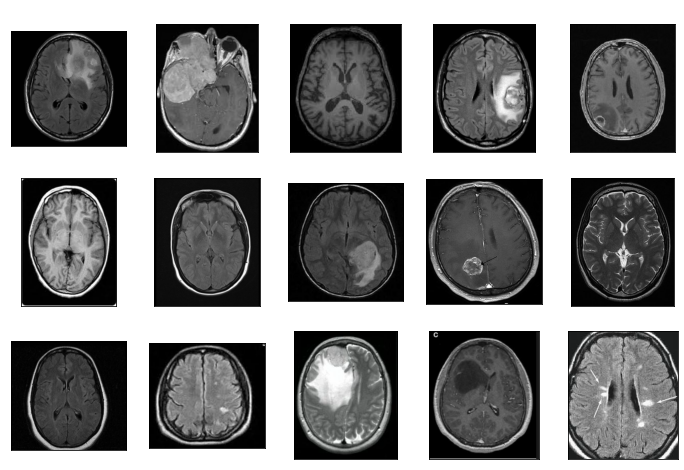

In [58]:
plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [59]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size=0.95, random_state=0)
train_new, valid = train_test_split(train, train_size=0.90, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (216, 2)
test set shape: (13, 2)
validation set shape: (24, 2)


# Data Augmentation

In [60]:
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [61]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'filepaths', y_col ='labels',
                                              target_size = (150,150), batch_size = 16, 
                                              class_mode = 'binary', shuffle = True)
val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(150,150), x_col = 'filepaths', y_col ='labels', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)
test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (150,150), x_col = 'filepaths', y_col ='labels',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 216 validated image filenames belonging to 2 classes.
Found 24 validated image filenames belonging to 2 classes.
Found 13 validated image filenames belonging to 2 classes.


In [62]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

# CNN model

In [63]:
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', input_shape = (200,200,3),
                                                     include_top=False)
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_3   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 128)               196736    
                                                                 
 batch_normalization_815 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

In [64]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=6, monitor='val_accuracy', verbose=1),
]


model.compile(loss='binary_crossentropy', optimizer=Adam(lr = 0.0001), metrics=['accuracy'])


history = model.fit(train_gen, validation_data = val_gen, epochs = 40, 
                    callbacks = [callbacks], verbose = 1)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


14/14 [==============================] - 26s 664ms/step - loss: 0.7125 - accuracy: 0.6343 - val_loss: 0.7913 - val_accuracy: 0.5833
Epoch 2/40
14/14 [==============================] - 6s 426ms/step - loss: 0.6292 - accuracy: 0.6944 - val_loss: 0.7396 - val_accuracy: 0.5833
Epoch 3/40
14/14 [==============================] - 6s 423ms/step - loss: 0.5008 - accuracy: 0.7870 - val_loss: 0.6285 - val_accuracy: 0.7917
Epoch 4/40
14/14 [==============================] - 6s 432ms/step - loss: 0.4414 - accuracy: 0.7917 - val_loss: 0.4848 - val_accuracy: 0.7917
Epoch 5/40
14/14 [==============================] - 7s 484ms/step - loss: 0.4660 - accuracy: 0.8056 - val_loss: 0.3864 - val_accuracy: 0.8750
Epoch 6/40
14/14 [==============================] - 3s 197ms/step - loss: 0.3833 - accuracy: 0.8380 - val_loss: 0.3956 - val_accuracy: 0.9167
Epoch 7/40
14/14 [==============================] - 6s 426ms/step - loss: 0.4241 - accuracy: 0.8009 - val_loss: 0.3371 - val_accuracy: 0.8750
Epoch 8/40
14/14

In [65]:
model.load_weights("Tumor_classifier_model.h5")
model.evaluate(test_gen)

1/1 [==============================] - 0s 136ms/step - loss: 0.2426 - accuracy: 0.9231


[0.2426438182592392, 0.9230769276618958]

# Model performance

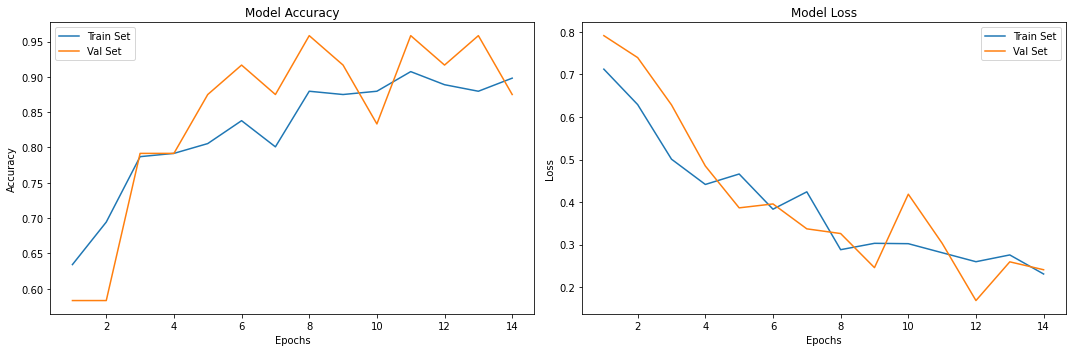

In [66]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()